<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/models/FFA-net/ffa_kitti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import *
from tensorflow.keras import backend as K
import math

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing and loading of data

In [38]:
#ls drive/MyDrive/reside/archive/clear_images drive/MyDrive/reside/archive/haze  

In [ ]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    
    img = tf.io.decode_png(img, channels = 3)
    img = tf.image.resize(img, size = (352 , 1216), antialias = True)
    img = img / 255.0
    return img

In [ ]:
def dataset_preposses(orig_img_path='/content/drive/MyDrive/generated_dataset/trans',hazy_img_path='/content/drive/MyDrive/generated_dataset/hazy',percentage=0.1,validation_size=200,test_size=64,seed_val=200):
    train_img = []
    val_img = []
    random.seed=seed_val
    orig_img = glob.glob(orig_img_path + '/*.png')
    n = len(orig_img)
    random.shuffle(orig_img)
    red_keys=orig_img[:]                                 #redundant keys to avoid key error
    train_keys = orig_img[:int(0.9*n*percentage)]
    #print(0.9*n*percentage)
    #print(len(train_keys))
    val_keys = orig_img[-int(0.1*n*percentage):]
    #print(len(val_keys))
    split_dict = {}
    #i=0
    for key in red_keys:
      split_dict[key]='red'
      #i+=1
    #print(i)
    for key in train_keys:
      split_dict[key] = 'train'
    for key in val_keys:
      split_dict[key] = 'val'
      
    hazy_img = glob.glob(hazy_img_path + '/*.png')
    for img in hazy_img:
      
      img_name = img.split('/')[-1][:-4].split('_')[0]
      orig_path = orig_img_path + '/' + img_name+'.png'
      if (split_dict[orig_path] == 'train'):
        train_img.append([img, orig_path])
      if (split_dict[orig_path] == 'val'):
        val_img.append([img, orig_path])
      

    return train_img, val_img


def gen_dataset(ar):
  '''
  parameters
  list of paths
  return
  list with gt attached 
  '''
  orig_path='/content/drive/MyDrive/kitti/gt'
  haze_pth='/content/drive/MyDrive/kitti/hazy'
  lst=[]
  for i in ar:
    name=i.split('/')[-1].split('_')[0]
    pthlist=[i,orig_path+'/'+name+'.jpg']
    lst.append(pthlist)
  return lst

def data_path(orig_img_path = '/content/drive/MyDrive/kitti/gt', hazy_img_path = '/content/drive/MyDrive/kitti/hazy'):
  
  (a,b,c)=dataset_preposses(orig_path=orig_img_path,haze_path=hazy_img_path)
  a=gen_dataset(a)
  b=gen_dataset(b)
  return a,b

In [ ]:
def dataloader(train_data, val_data, batch_size):
    print(len(train_data))
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    return train, val

In [ ]:
def display_img(model, hazy_img, orig_img):
    
    dehazed_img = model(hazy_img,training = False)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(3, 1, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        directory='/content/drive/MyDrive/Test/padCheck'
        os.chdir(directory)
        filename=str(i)+'.jpg'
        tf.keras.preprocessing.image.save_img(filename,display_list[i],)
        #plt.imsave('plt'+filename,display_list[i])
    plt.show()

# Network Function

In [39]:
def default_conv(in_channels, out_channels, kernel_size, bias=True,activation='relu'):
    return tf.keras.layers.Conv2D(out_channels, kernel_size,padding='same', use_bias=bias,activation=activation)
    
class PixAtLayer(tf.keras.Model):
    def __init__(self, channel):
        super(PixAtLayer, self).__init__()
        self.pa = tf.keras.Sequential()
        self.pa.add(tf.keras.layers.Conv2D(channel // 8, 1, padding='valid',activation='relu'))
        self.pa.add(tf.keras.layers.Conv2D( 1, 1,activation='sigmoid'))
    def call(self, x):
        y = self.pa(x)
        #return y
        return x * y

    def model(self):
        x = Input(shape = (352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))

class adapavgpooling(tf.keras.Model):
  def __init__(self,outputsize):
    super(adapavgpooling,self).__init__()
    self.outputsize=outputsize

  def call(self,x):
    x_shape=tf.keras.backend.int_shape(x)
    batchsize1,dim1,dim2,channels1=x_shape
    stride=np.floor(dim2/self.outputsize).astype(np.int32)
    kernels=dim1-(self.outputsize-1)*stride
    adpooling=tf.keras.layers.AveragePooling2D(pool_size=(kernels,kernels),strides=(stride,stride))(x)
    return adpooling

  def model(self):
        x = Input(shape = (352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))
'''    
def adapavgpooling(x,outsize):
    x_shape=tf.keras.backend.int_shape(x)
    batchsize1,dim1,dim2,channels1=x_shape
    stride=np.floor(dim1/outsize).astype(np.int32)
    kernels=dim1-(outsize-1)*stride
    adpooling=tf.keras.layers.AveragePooling2D(pool_size=(kernels,kernels),strides=(stride,stride))(x)
    
    return adpooling
'''
class ChanAtLayer(tf.keras.Model):
  def __init__(self, channel):
      super(ChanAtLayer, self).__init__()
      #self.avg_pool = tf.keras.layers.GlobalAveragePooling2D()
      self.ca = tf.keras.Sequential()
      self.ca.add(tf.keras.layers.Conv2D(channel // 8, 1,activation='relu'))
      self.ca.add(tf.keras.layers.Conv2D(channel, 1, activation='sigmoid'))
      self.adPool=adapavgpooling(1)
  def call(self, x):
      y = self.adPool(x)
      #print(y.shape)
      y = self.ca(y)
      
      return x * y

  def model(self):
        x = Input(shape = (352, 1216, 64))
        return Model(inputs=[x], outputs=self.call(x))


In [3]:
#sub = PixAtLayer(64)
#sub.model().summary()
sub1 = ChanAtLayer(64)
sub1.model().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 352, 1216, 6 0                                            
__________________________________________________________________________________________________
adapavgpooling (adapavgpooling) (None, 1, 1, 64)     0           input_1[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1, 1, 64)     1096        adapavgpooling[0][0]             
__________________________________________________________________________________________________
tf.math.multiply (TFOpLambda)   (None, 352, 1216, 64 0           input_1[0][0]                    
                                                                 sequential[0][0]             

In [40]:
class Block_layer(tf.keras.Model):
    def __init__(self, conv, dim, kernel_size,):
        super(Block_layer, self).__init__()
        self.conv1=conv(dim,dim, kernel_size, bias=True,activation='relu')
        
        self.conv2=conv(dim,dim, kernel_size, bias=True)
        self.calayer=ChanAtLayer(dim)
        self.palayer=PixAtLayer(dim)
    def call(self, x):
        res=self.conv1(x)
        res=res+x 
        res=self.conv2(res)
        res=self.calayer(res)
        res=self.palayer(res)
        res += x 
        return res

    def model(self):
        x = Input(shape = (352, 1216, 64))
        return Model(inputs=[x], outputs=self.call(x))


In [41]:
class Group_layer(tf.keras.Model):
    def __init__(self, conv, dim, kernel_size, blocks):
        super(Group_layer, self).__init__()
        modules = [ Block_layer(conv, dim, kernel_size)  for _ in range(blocks)]
        modules.append(tf.keras.layers.Conv2D(dim, kernel_size,padding='same'))
        self.gp = tf.keras.Sequential()
        for lay in modules:
          self.gp.add(lay)
        
    def call(self,input_tensor):
        res = self.gp(input_tensor)
        #res =tf.keras.layers.Add()([res,input_tensor])
        res+=input_tensor
        return res

    def model(self):
        x = Input(shape = (352, 1216, 64))
        return Model(inputs=[x], outputs=self.call(x))

In [42]:
#sub1 =Group_layer(default_conv,64,3,6)
#sub1.model().summary()

In [43]:
class FFAnet(tf.keras.Model):
    def __init__(self,gps,blocks,conv=default_conv):
        super(FFAnet, self).__init__()
        # define all layers in init
        # Layer of Block 1
        self.gps=gps
        self.dim=64
        kernel_size=3
        pre_process = [tf.keras.layers.Conv2D(self.dim, kernel_size)]
        assert self.gps==3
        self.g1= Group_layer(conv, self.dim, kernel_size,blocks=blocks)
        self.g2= Group_layer(conv, self.dim, kernel_size,blocks=blocks)
        self.g3= Group_layer(conv, self.dim, kernel_size,blocks=blocks)
        l=[
            adapavgpooling(1),
            tf.keras.layers.Conv2D(self.dim//16,1,padding='valid'),
            
            tf.keras.layers.Conv2D(self.dim*self.gps, 1, padding='valid', use_bias=True,activation='sigmoid')
            
            ]
       
        self.ca=tf.keras.Sequential()
        for lay in l:
          self.ca.add(lay)
        self.palayer=PixAtLayer(self.dim)

        post_precess = [
            conv(self.dim, self.dim, kernel_size),
            conv(self.dim, 3, kernel_size)]

        self.pre = tf.keras.Sequential(conv(3,self.dim, kernel_size),name='preprocess')

        self.post = tf.keras.Sequential(name='postprocess')
        for lay in post_precess:
          self.post.add(lay)
        
    def call(self, input_tensor = (352, 1216, 3), training=False):
        # forward pass: block 1 
        x = self.pre(input_tensor)
        res1=self.g1(x)
        res2=self.g2(res1)
        res3=self.g3(res2)
        w=tf.keras.layers.concatenate([res1,res2,res3],axis=-1)
        w=self.ca(w)
        w=tf.keras.layers.Reshape((1,self.gps,self.dim))(w)
        out=w[:,:,0]*res1+w[:,:,1]*res2+w[:,:,2]*res3
        out=self.palayer(out)
        x=self.post(out)
        return x + input_tensor
        #return out
       
    def model(self):
        x = Input(shape = (352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))

    def build_graph(self):
        x = Input(shape=(352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 352, 1216, 3 0                                            
__________________________________________________________________________________________________
preprocess (Sequential)         (None, 352, 1216, 64 1792        input_10[0][0]                   
__________________________________________________________________________________________________
group_layer_12 (Group_layer)    (None, 352, 1216, 64 1471067     preprocess[0][0]                 
__________________________________________________________________________________________________
group_layer_13 (Group_layer)    (None, 352, 1216, 64 1471067     group_layer_12[0][0]             
____________________________________________________________________________________________

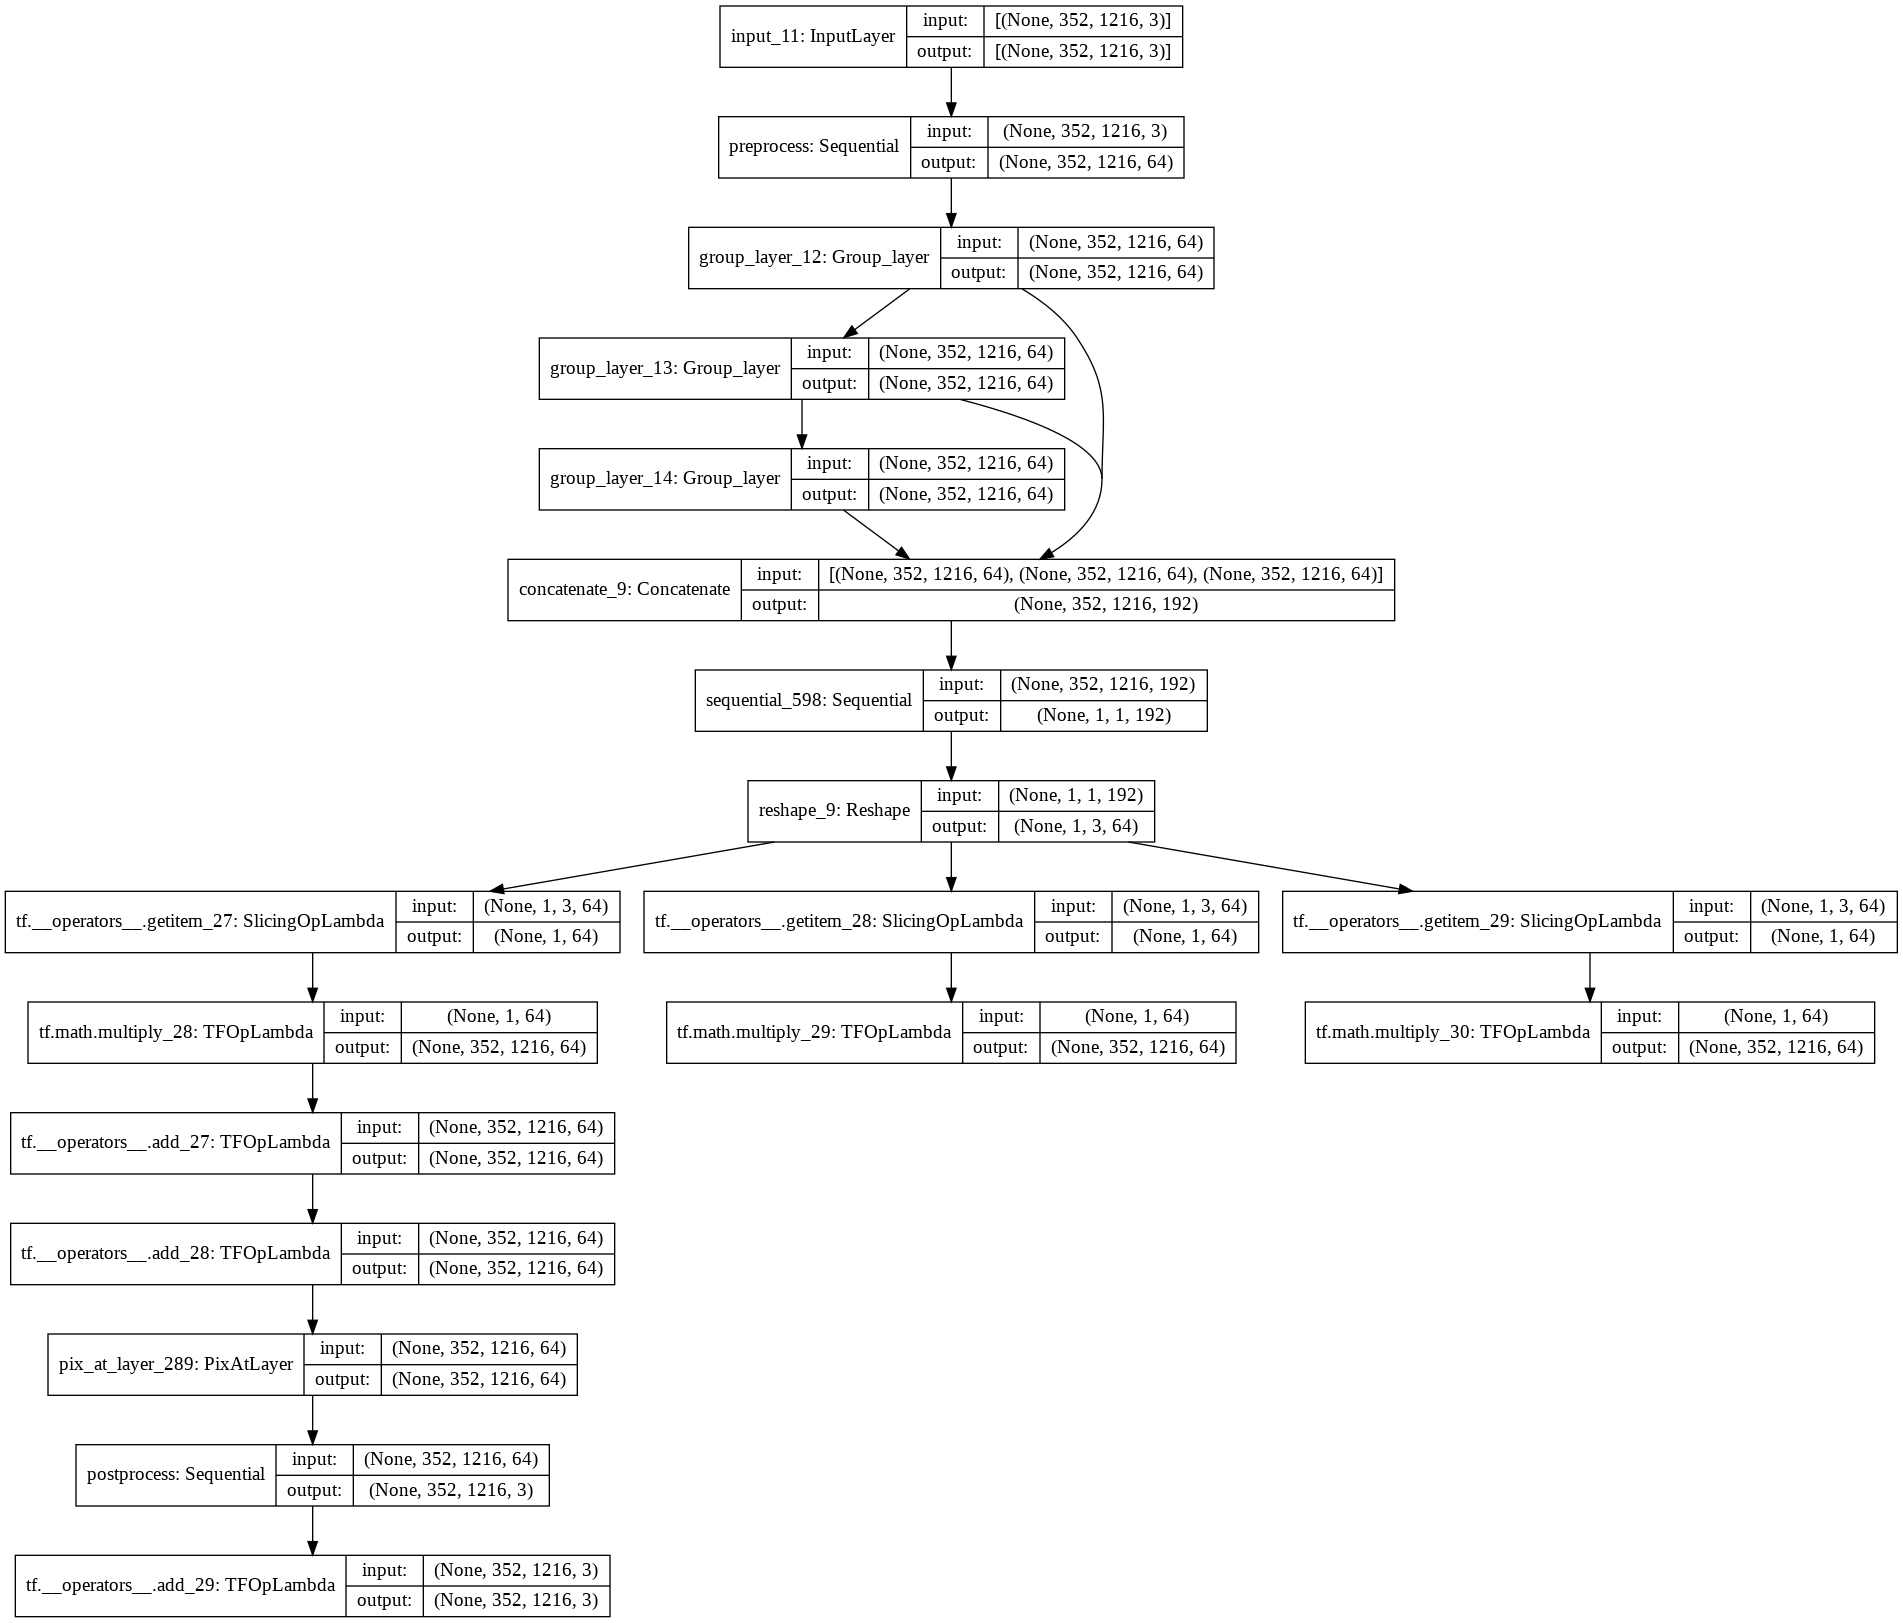

In [44]:
model =FFAnet(gps=3,blocks=19)
model.model().summary()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(
    model.build_graph(),                      # here is the trick (for now)
    to_file='model.png', dpi=96,              # saving  
    show_shapes=True, show_layer_names=True,  # show shapes and layer name
    expand_nested=False                       # will show nested block
)

# Transfer Learning

In [45]:
import torch
pretrain=torch.load('/content/drive/MyDrive/ots_train_ffa_3_19.pk',map_location=torch.device('cpu'))
pretrain.keys()

dict_keys(['step', 'max_psnr', 'max_ssim', 'ssims', 'psnrs', 'losses', 'model'])

In [46]:
pretrain['model'].keys()

odict_keys(['module.g1.gp.0.conv1.weight', 'module.g1.gp.0.conv1.bias', 'module.g1.gp.0.conv2.weight', 'module.g1.gp.0.conv2.bias', 'module.g1.gp.0.calayer.ca.0.weight', 'module.g1.gp.0.calayer.ca.0.bias', 'module.g1.gp.0.calayer.ca.2.weight', 'module.g1.gp.0.calayer.ca.2.bias', 'module.g1.gp.0.palayer.pa.0.weight', 'module.g1.gp.0.palayer.pa.0.bias', 'module.g1.gp.0.palayer.pa.2.weight', 'module.g1.gp.0.palayer.pa.2.bias', 'module.g1.gp.1.conv1.weight', 'module.g1.gp.1.conv1.bias', 'module.g1.gp.1.conv2.weight', 'module.g1.gp.1.conv2.bias', 'module.g1.gp.1.calayer.ca.0.weight', 'module.g1.gp.1.calayer.ca.0.bias', 'module.g1.gp.1.calayer.ca.2.weight', 'module.g1.gp.1.calayer.ca.2.bias', 'module.g1.gp.1.palayer.pa.0.weight', 'module.g1.gp.1.palayer.pa.0.bias', 'module.g1.gp.1.palayer.pa.2.weight', 'module.g1.gp.1.palayer.pa.2.bias', 'module.g1.gp.2.conv1.weight', 'module.g1.gp.2.conv1.bias', 'module.g1.gp.2.conv2.weight', 'module.g1.gp.2.conv2.bias', 'module.g1.gp.2.calayer.ca.0.weight'

In [78]:
model.layers

In [53]:
w=pretrain['model']['module.pre.0.weight']

In [104]:

w=np.moveaxis(pretrain['model']['module.ca.3.weight'].numpy(),(0,1),(-1,-2))
print(w.shape)
b=pretrain['model']['module.ca.3.bias'].numpy()

(1, 1, 4, 192)


In [109]:
model.layers[-4].layers[2].set_weights([w,b])

In [115]:
model.layers[0].layers[0].layers[0].layers#.get_weights()[0].shape

In [113]:
model.save_weights('/content/drive/MyDrive/kitti_nets/ffa/weights/')

# train

In [ ]:
# Hyperparameters
epochs = 10
batch_size = 1

train_data, val_data = dataset_preposses(orig_img_path = '/content/drive/MyDrive/kitti/gt', hazy_img_path = '/content/drive/MyDrive/kitti/hazy',percentage=0.01)
train, val = dataloader(train_data, val_data, batch_size)

optimizer = Adam(learning_rate = 1e-4,beta_1=0.9,beta_2=0.999,epsilon=1e-8)

#net.load_weights('/content/drive/MyDrive/nets/ffa/weights')
train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

54


In [ ]:
model=tf.keras.models.load_model('/content/drive/MyDrive/kitti_nets/ffa/')

In [ ]:
def lr_schedule_cosdecay(epoch,T=100,init_lr=1e-4):
  #T=100
  t=epoch;
  lr=0.5*(1+math.cos(t*math.pi/T))*init_lr;
  return lr

def lossVGG(y_true, y_pred):
	vgg = VGG19(include_top=False, weights='imagenet')
	vgg.trainable = False
	content_layers = 'block2_conv2'

	lossModel = Model(vgg.input, vgg.get_layer(content_layers).output)

	vggX = lossModel(y_pred)
	vggY = lossModel(y_true)
	
	return K.mean(K.square(vggX - vggY)) 

def my_loss(y_true, y_pred):
  mae = tf.keras.losses.MeanAbsoluteError()
  mae = (y_true, y_pred)
  return mae+0.04*lossVGG(y_true, y_pred) 

In [ ]:


def train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer):
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()
        
        # training loop
        
        optimizer.learning_rate=lr_schedule_cosdecay(epoch)
        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:

                train_logits = net(train_batch_haze, training = True)
                #print(train_logits.shape)
                loss = my_loss(train_batch_orig, train_logits)

            grads = tape.gradient(loss, net.trainable_weights)
            
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 32 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        # validation loop
        
        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
            val_logits = net(val_batch_haze, training = False)
            val_loss_tracker.update_state(val_batch_orig, val_logits)
            
            if step % 32 ==0:
                display_img(net, val_batch_haze, val_batch_orig)
        
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        #net.save('trained_model')  
        #net.save_weights('/content/drive/MyDrive/nets/ffa/weights')         # save the model(variables, weights, etc)
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()

In [ ]:
%%time
train_model(2, train, val,model, train_loss_tracker, val_loss_tracker, optimizer)


Start of epoch 0 Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5
80142336/80134624 [==============================] - 1s 0us/step


In [58]:
model.save('/content/drive/MyDrive/kitti_nets/ffa/')

model.save_weights('/content/drive/MyDrive/kitti_nets/ffa/weights/')
#model=net

#model.model().summary()

ValueError: ignored

## Test

In [ ]:
import cv2
import matplotlib.pyplot as plt

def evaluate_gen(net):
    
    #test_img = glob.glob(test_img_path +'/*.jpg')
    test_img=glob.glob('/content/drive/MyDrive/Final_compare/HAZY/*.jpg')
    #random.shuffle(test_img)
    i=0;
    for img in test_img:
        print(img)
        img = tf.io.read_file(img)
        img = tf.io.decode_jpeg(img, channels = 3)
        
        img = tf.image.resize(img, size = (412,548), antialias = True)
        
        img = img / 255.0
        print(i,end=" ")
        img = tf.expand_dims(img, axis = 0)      #transform input image from 3D to 4D ###
        
        dehaze =net(img, training = True)
        dehaze=tf.image.resize(dehaze, size = (413,550), antialias = True)
        #plt.figure(figsize = (80, 80))
        
        #display_list = [img[0], dehaze[0]]       #make the first dimension zero
        im=dehaze[0]
        directory = '/content/drive/MyDrive/Final_compare/ffa'
        os.chdir(directory)
        filename = str(i) + '_outdoor_gen.jpg'
        #print(filename)
        #cv2.imwrite(filename,im) 
        #plt.imsave(filename,im)
        tf.keras.preprocessing.image.save_img(
    filename, 

im)

        os.chdir('/content')
        i+=1;



In [ ]:
#new_model = tf.keras.models.load_model('/content/drive/MyDrive/nets/gca',compile=False)
#new_model = tf.keras.models.load_model('/content/drive/MyDrive/nets/gca/trained_model',compile=False)
#new_model = tf.keras.models.load_model('/content/drive/MyDrive/nets/test_custom_loss_net',compile=False)

net = FFAnet(gps=3,blocks=8)
net.load_weights('/content/drive/MyDrive/nets/ffa/weights')
#evaluate_gen(new_model)
evaluate_gen(net)

/content/drive/MyDrive/Final_compare/HAZY/0_outdoor_hazy.jpg
0 /content/drive/MyDrive/Final_compare/HAZY/4_outdoor_hazy.jpg
1 /content/drive/MyDrive/Final_compare/HAZY/2_outdoor_hazy.jpg
2 /content/drive/MyDrive/Final_compare/HAZY/5_outdoor_hazy.jpg
3 /content/drive/MyDrive/Final_compare/HAZY/3_outdoor_hazy.jpg
4 /content/drive/MyDrive/Final_compare/HAZY/1_outdoor_hazy.jpg
5 /content/drive/MyDrive/Final_compare/HAZY/6_outdoor_hazy.jpg
6 /content/drive/MyDrive/Final_compare/HAZY/7_outdoor_hazy.jpg
7 /content/drive/MyDrive/Final_compare/HAZY/8_outdoor_hazy.jpg
8 /content/drive/MyDrive/Final_compare/HAZY/9_outdoor_hazy.jpg
9 /content/drive/MyDrive/Final_compare/HAZY/10_outdoor_hazy.jpg
10 /content/drive/MyDrive/Final_compare/HAZY/11_outdoor_hazy.jpg
11 /content/drive/MyDrive/Final_compare/HAZY/12_outdoor_hazy.jpg
12 /content/drive/MyDrive/Final_compare/HAZY/13_outdoor_hazy.jpg
13 /content/drive/MyDrive/Final_compare/HAZY/14_outdoor_hazy.jpg
14 /content/drive/MyDrive/Final_compare/HAZY/15_

## Learn

In [ ]:
import torch.nn as nn
import torch

def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(in_channels, out_channels, kernel_size,padding=(kernel_size//2), bias=bias)
    
class PALayer(nn.Module):
    def __init__(self, channel):
        super(PALayer, self).__init__()
        self.pa = nn.Sequential(
                nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 8, 1, 1, padding=0, bias=True),
                nn.Sigmoid()
        )
    def forward(self, x):
        y = self.pa(x)
        return x * y

class CALayer(nn.Module):
    def __init__(self, channel):
        super(CALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.ca = nn.Sequential(
                nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 8, channel, 1, padding=0, bias=True),
                nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.ca(y)
        return x * y

class Block(nn.Module):
    def __init__(self, conv, dim, kernel_size,):
        super(Block, self).__init__()
        self.conv1=conv(dim, dim, kernel_size, bias=True)
        self.act1=nn.ReLU(inplace=True)
        self.conv2=conv(dim,dim,kernel_size,bias=True)
        self.calayer=CALayer(dim)
        self.palayer=PALayer(dim)
    def forward(self, x):
        res=self.act1(self.conv1(x))
        res=res+x 
        res=self.conv2(res)
        res=self.calayer(res)
        res=self.palayer(res)
        res += x 
        return res
class Group(nn.Module):
    def __init__(self, conv, dim, kernel_size, blocks):
        super(Group, self).__init__()
        modules = [ Block(conv, dim, kernel_size)  for _ in range(blocks)]
        modules.append(conv(dim, dim, kernel_size))
        self.gp = nn.Sequential(*modules)
    def forward(self, x):
        res = self.gp(x)
        res += x
        return res

class FFA(nn.Module):
    def __init__(self,gps,blocks,conv=default_conv):
        super(FFA, self).__init__()
        self.gps=gps
        self.dim=64
        kernel_size=3
        pre_process = [conv(3, self.dim, kernel_size)]
        assert self.gps==3
        self.g1= Group(conv, self.dim, kernel_size,blocks=blocks)
        self.g2= Group(conv, self.dim, kernel_size,blocks=blocks)
        self.g3= Group(conv, self.dim, kernel_size,blocks=blocks)
        self.ca=nn.Sequential(*[
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(self.dim*self.gps,self.dim//16,1,padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.dim//16, self.dim*self.gps, 1, padding=0, bias=True),
            nn.Sigmoid()
            ])
        self.palayer=PALayer(self.dim)

        post_precess = [
            conv(self.dim, self.dim, kernel_size),
            conv(self.dim, 3, kernel_size)]

        self.pre = nn.Sequential(*pre_process)
        self.post = nn.Sequential(*post_precess)

    def forward(self, x1):
        x = self.pre(x1)
        res1=self.g1(x)
        res2=self.g2(res1)
        res3=self.g3(res2)
        #return res3
        w=torch.cat([res1,res2,res3],dim=1)
        w=self.ca(w)
        #return w
        w=w.view(-1,self.gps,self.dim)[:,:,:,None,None]
        #print(h.shape)
        #return h
        
        out=w[:,0,::]*res1+w[:,1,::]*res2+w[:,2,::]*res3
        
        #return out
        out=self.palayer(out)
        #return out
        x=self.post(out)
        return x + x1

In [ ]:
from torchsummary import summary
net=FFA(gps=3,blocks=6)
if torch.cuda.is_available():
    net.cuda()
print(summary(net, (3, 412, 548)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 412, 548]           1,792
            Conv2d-2         [-1, 64, 412, 548]          36,928
              ReLU-3         [-1, 64, 412, 548]               0
            Conv2d-4         [-1, 64, 412, 548]          36,928
 AdaptiveAvgPool2d-5             [-1, 64, 1, 1]               0
            Conv2d-6              [-1, 8, 1, 1]             520
              ReLU-7              [-1, 8, 1, 1]               0
            Conv2d-8             [-1, 64, 1, 1]             576
           Sigmoid-9             [-1, 64, 1, 1]               0
          CALayer-10         [-1, 64, 412, 548]               0
           Conv2d-11          [-1, 8, 412, 548]             520
             ReLU-12          [-1, 8, 412, 548]               0
           Conv2d-13          [-1, 1, 412, 548]               9
          Sigmoid-14          [-1, 1, 4

In [ ]:
a=torch.rand(8,10,4,5)

In [ ]:
a.shape

torch.Size([8, 10, 4, 5])

In [ ]:
b=a.view([-1,1,4])[:,:,:,None,None]

In [ ]:
b.shape

torch.Size([400, 1, 4, 1, 1])

In [ ]:
a

tensor([[[[9.3083e-01, 3.4149e-01, 6.2464e-02, 1.6509e-01, 3.1680e-02],
          [7.2932e-01, 8.6349e-01, 7.6379e-01, 5.4104e-01, 9.7537e-01],
          [4.5767e-01, 4.5184e-01, 9.1770e-01, 8.9308e-01, 1.4236e-01],
          [5.9230e-01, 5.2894e-01, 5.9084e-01, 3.4301e-01, 6.7397e-01]],

         [[2.4420e-01, 9.0421e-01, 8.0007e-01, 2.4886e-01, 7.9879e-01],
          [9.1165e-01, 7.0346e-01, 7.9042e-01, 6.0191e-01, 8.5700e-01],
          [9.2220e-01, 9.7841e-01, 4.9970e-01, 7.1415e-01, 9.4095e-01],
          [6.4002e-01, 7.6082e-01, 4.6441e-01, 6.2140e-01, 1.4274e-01]],

         [[8.4974e-01, 2.5507e-01, 8.0035e-01, 5.1506e-01, 1.2641e-01],
          [4.8470e-01, 4.9259e-01, 4.6987e-01, 2.3502e-01, 4.9751e-01],
          [9.3467e-01, 4.2462e-01, 7.4162e-01, 9.8951e-01, 3.1179e-01],
          [5.8126e-01, 4.0467e-01, 9.0122e-02, 7.9426e-01, 5.9412e-01]],

         ...,

         [[9.4131e-01, 1.4768e-01, 9.0415e-01, 4.3891e-01, 5.5551e-01],
          [2.2357e-01, 2.0926e-01, 5.8239e-